In [1]:
import torch
import numpy as np
import seaborn as sns
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torchsummary import summary
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [3]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

In [4]:
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

In [5]:
print(train_dataset)
print("--------------------------------------------------")
print(test_dataset)

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )
--------------------------------------------------
Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )


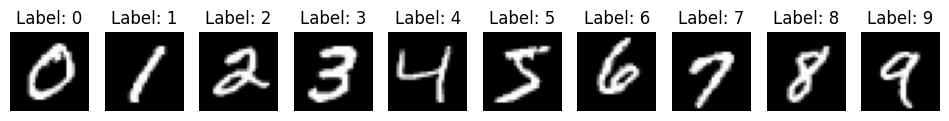

In [6]:
images_by_class = {}

for image, label in train_dataset:
    if label not in images_by_class:
        images_by_class[label] = image
    if len(images_by_class) == 10:
        break

fig, axes = plt.subplots(1, 10, figsize=(12, 3))
for label, ax in enumerate(axes):
    img = images_by_class[label]  # Get the image for the corresponding label
    ax.imshow(img.squeeze(), cmap='gray')
    ax.set_title(f"Label: {label}")
    ax.axis("off")
plt.show()

In [7]:
batch_size = 64
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [8]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # First Convolutional layer (1 input channel for grayscale images, 32 output channels, 3x3 kernel)
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        # Second convolutional layer
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        # Max pooling layer with kernel size 2x2 with stride 2
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # Fully connected layers
        self.fc1 = nn.Linear(64 * 7 * 7, 128)  # Image dims reduce from 28x28 to 7x7
        self.fc2 = nn.Linear(128, 10)  # 10 output classes for MNIST

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

#### **`Output Dim. = [(Input Dim. - Kernel Dim. + 2P) / Stride] + 1`**
<font color="yellow">Shape: 1 x 28 x 28 (Depth, Height, Weight) </font> \\
*After Conv1:* `Output Dim. = [28 - 3 + 2(1) / 1] + 1 = 28` \\
<font color="yellow">Shape: 32 x 28 x 28 </font> \\
*After Pool1:* `Output Dim. = [28 - 2 + 2(0) / 2] + 1 = 14` \\
<font color="yellow">Shape: 32 x 14 x 14 </font> \\
*After Conv2:* `Output Dim. = [14 - 3 + 2(1) / 1] + 1 = 14` \\
<font color="yellow">Shape: 64 x 14 x 14 </font> \\
*After Pool2:* `Output Dim. = [14 - 2 + 2(0) / 2] + 1 = 7` \\
<font color="yellow"> Shape: 64 x 7 x 7 </font>

In [9]:
model = CNN().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
         MaxPool2d-2           [-1, 32, 14, 14]               0
            Conv2d-3           [-1, 64, 14, 14]          18,496
         MaxPool2d-4             [-1, 64, 7, 7]               0
            Linear-5                  [-1, 128]         401,536
            Linear-6                   [-1, 10]           1,290
Total params: 421,642
Trainable params: 421,642
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.36
Params size (MB): 1.61
Estimated Total Size (MB): 1.97
----------------------------------------------------------------


In [10]:
learning_rate = 0.001

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

In [11]:
num_epochs = 10

print("Training started!")
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    average_loss = total_loss / len(train_loader)
    training_accuracy = 100 * correct / total
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {average_loss:.4f}, Training Accuracy: {training_accuracy:.2f}%")

print("Training completed!")

Training started!
Epoch [1/10], Loss: 2.2494, Training Accuracy: 30.75%
Epoch [2/10], Loss: 1.9864, Training Accuracy: 63.26%
Epoch [3/10], Loss: 1.2147, Training Accuracy: 76.81%
Epoch [4/10], Loss: 0.6436, Training Accuracy: 83.99%
Epoch [5/10], Loss: 0.4658, Training Accuracy: 87.10%
Epoch [6/10], Loss: 0.3868, Training Accuracy: 88.90%
Epoch [7/10], Loss: 0.3393, Training Accuracy: 90.19%
Epoch [8/10], Loss: 0.3053, Training Accuracy: 91.01%
Epoch [9/10], Loss: 0.2797, Training Accuracy: 91.83%
Epoch [10/10], Loss: 0.2587, Training Accuracy: 92.39%
Training completed!


In [15]:
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

accuracy = (all_preds == all_labels).sum() / len(all_labels)
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall:    {recall:.2f}")
print(f"F1 Score:  {f1:.2f}")

Accuracy: 0.93
Precision: 0.93
Recall:    0.93
F1 Score:  0.93


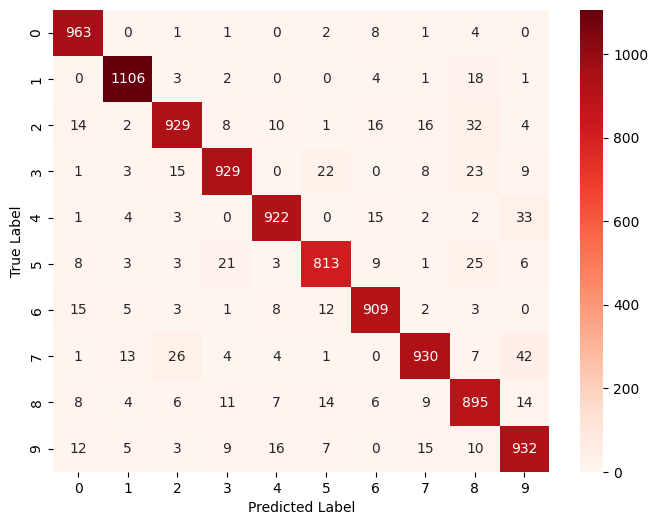

In [13]:
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Reds",
            xticklabels=range(10), yticklabels=range(10))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [14]:
torch.save(model.state_dict(), "cnn_mnist.pth")